In [ ]:
!pip install datasets pillow torch torchvision matplotlib scikit-learn tqdm


In [1]:
from datasets import load_dataset

# Load dataset
dataset = load_dataset("filnow/furniture-synthetic-dataset")

c:\Users\nitik\OneDrive\Desktop\product-recommender\.venv\Lib\site-packages\tqdm\auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm
c:\Users\nitik\OneDrive\Desktop\product-recommender\.venv\Lib\site-packages\huggingface_hub\file_download.py:143: UserWarning: `huggingface_hub` cache-system uses symlinks by default to efficiently store duplicated files but your machine does not support them in C:\Users\nitik\.cache\huggingface\hub\datasets--filnow--furniture-synthetic-dataset. Caching files will still work but in a degraded version that might require more space on your disk. This warning can be disabled by setting the `HF_HUB_DISABLE_SYMLINKS_WARNING` environment variable. For more details, see https://huggingface.co/docs/huggingface_hub/how-to-cache#limitations.
To support symlinks on Windows, you either need to activate Developer Mode or t

                                               image type       style  \
0  <PIL.PngImagePlugin.PngImageFile image mode=RG...  bed    colonial   
1  <PIL.PngImagePlugin.PngImageFile image mode=RG...  bed     bauhaus   
2  <PIL.PngImagePlugin.PngImageFile image mode=RG...  bed    bohemian   
3  <PIL.PngImagePlugin.PngImageFile image mode=RG...  bed   victorian   
4  <PIL.PngImagePlugin.PngImageFile image mode=RG...  bed  provincial   

     color material     shape          details  room_type price_range  \
0     gray   marble  wingback   tall headboard       kids    standard   
1     gold     wool   modular      wooden legs       kids       elite   
2   silver     cork    curved     leather trim  penthouse     premium   
3  emerald   bamboo  platform  adjustable base       loft      luxury   
4    azure      oak   angular        wide base    nursery       elite   

                                              prompt  
0  Professional product photography of a colonial...  
1  Professio

KeyError: 'label'

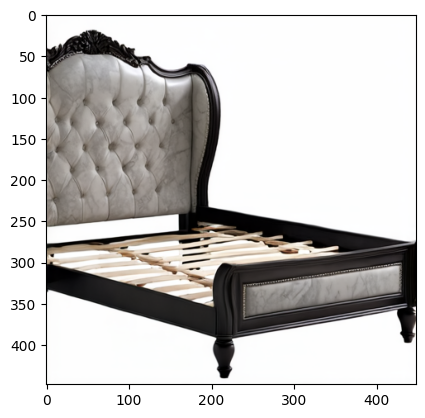

In [2]:
import pandas as pd
from PIL import Image
import matplotlib.pyplot as plt

df = pd.DataFrame(dataset["train"])
print(df.head())

# show few images
for i in range(5):
    plt.imshow(df["image"][i])
    plt.title(f"{df['label'][i]} - {df['color'][i]}, {df['material'][i]}")
    plt.axis("off")
    plt.show()

In [ ]:
import torch
from torchvision import models, transforms
import numpy as np
from tqdm.notebook import tqdm

device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
print("Using device:", device)

# Preprocessing transform for ResNet
transform = transforms.Compose([
    transforms.Resize((224,224)),
    transforms.ToTensor(),
    transforms.Normalize(mean=[0.485, 0.456, 0.406],
                         std=[0.229, 0.224, 0.225]),
])

# Pretrained ResNet50
model = models.resnet50(pretrained=True)
model = torch.nn.Sequential(*list(model.children())[:-1])
model.to(device)
model.eval()

# Extract embeddings
embeddings = []
labels = []

for i in tqdm(range(len(df))):
    img = df["image"][i].convert("RGB")
    x = transform(img).unsqueeze(0).to(device)
    with torch.no_grad():
        emb = model(x).squeeze().cpu().numpy()
    embeddings.append(emb)
    labels.append(df["label"][i])

embeddings = np.array(embeddings)
print("Embeddings shape:", embeddings.shape)


In [ ]:
np.save("../backend/data/furniture_embeddings.npy", embeddings)
df.to_csv("../backend/data/furniture_metadata.csv", index=False)

In [ ]:
from sklearn.neighbors import NearestNeighbors

nbrs = NearestNeighbors(n_neighbors=6, metric="cosine")
nbrs.fit(embeddings)

In [ ]:
query_index = 0  # change number to test
distances, indices = nbrs.kneighbors([embeddings[query_index]])

# Plot query + results
plt.figure(figsize=(15, 3))
for i, idx in enumerate(indices[0]):
    plt.subplot(1, 6, i+1)
    plt.imshow(df["image"][idx])
    title = "Query" if i == 0 else f"Sim {i}"
    plt.title(f"{title}\n{df['label'][idx]}")
    plt.axis("off")
plt.show()